In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: preprocess_data(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: preprocess_data(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
tokenizer, x_train_padded, x_val_padded = tokenizer_and_pad_training(x_train, 
                                                                     x_val, 
                                                                     pad_len, 
                                                                     padding_type, 
                                                                     truncating_type)

In [38]:
dump(tokenizer, "../tokenizers/DL-tokenizer_100.pk1")

['../tokenizers/DL-tokenizer_100.pk1']

In [9]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [10]:
vocab = tokenizer.word_index

In [11]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

29198
Total time taken:  7.654593244999999


(51791, 300)

In [12]:
input_dim = embedding_matrix1.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  51791
Embedding dimensions:  300
Input sentence dimensions:  100


In [13]:
myCB = myCallbacks(metrics='acc', threshold=0.95)

# Feed-Forward Neural Network Model

In [14]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix1, 
                         input_len, 
                         trainable=True, 
                         n1=64, n2=32, 
                         kr=l2(0.015))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15537300  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 15,558,776
Trainable params: 15,558,776
Non-trainable params: 0
_________________________________________________________________


In [15]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=40, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/40
1313/1313 [==============================] - 168s 128ms/step - loss: 1.0237 - acc: 0.7265 - val_loss: 0.6334 - val_acc: 0.8299
Epoch 2/40
1313/1313 [==============================] - 170s 130ms/step - loss: 0.4926 - acc: 0.8844 - val_loss: 0.5308 - val_acc: 0.8534
Epoch 3/40
1313/1313 [==============================] - 173s 132ms/step - loss: 0.3302 - acc: 0.9393 - val_loss: 0.5722 - val_acc: 0.8360
Epoch 4/40
1313/1313 [==============================] - ETA: 0s - loss: 0.2363 - acc: 0.9683
Training accuracy above 0.95%...so training stopped...

1313/1313 [==============================] - 177s 135ms/step - loss: 0.2363 - acc: 0.9683 - val_loss: 0.4940 - val_acc: 0.8585


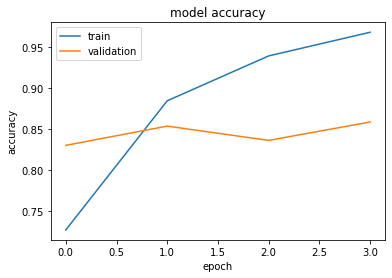

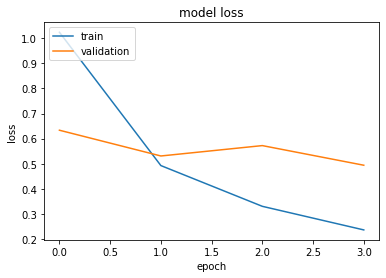

In [16]:
plot_curves(history1)

In [35]:
name = "FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [9]:
myDNN = model_load("../models/FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585.h5")

In [12]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [16]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8584656084656085

Precision:  [0.85026738 0.82875895 0.89473684 0.8836689 ]
Average Precision:  0.864358018867052

Recall:  [0.75714286 0.92292359 0.84519774 0.81443299]
Average nRecall:  0.8349242937466099

F1-Score:  [0.80100756 0.87331028 0.86926206 0.84763948]
Average F1-Score:  0.8478048445958679


# CNN Model

In [24]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix1, input_len, 
                         trainable=True, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.02))
myCNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          15537300  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 15,633,624
Trainable params: 15,633,624
Non-trainable params: 0
_________________________________________________________________


In [25]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=40, 
                     batch_size=64, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/40
657/657 [==============================] - 141s 215ms/step - loss: 0.9252 - acc: 0.7690 - val_loss: 0.6070 - val_acc: 0.8437
Epoch 2/40
657/657 [==============================] - 149s 227ms/step - loss: 0.5309 - acc: 0.8684 - val_loss: 0.5419 - val_acc: 0.8563
Epoch 3/40
657/657 [==============================] - 131s 199ms/step - loss: 0.4082 - acc: 0.9114 - val_loss: 0.5073 - val_acc: 0.8683
Epoch 4/40
657/657 [==============================] - 130s 198ms/step - loss: 0.3284 - acc: 0.9360 - val_loss: 0.5277 - val_acc: 0.8587
Epoch 5/40
657/657 [==============================] - 129s 196ms/step - loss: 0.2832 - acc: 0.9484 - val_loss: 0.5349 - val_acc: 0.8606
Epoch 6/40
657/657 [==============================] - ETA: 0s - loss: 0.2445 - acc: 0.9572
Training accuracy above 0.95%...so training stopped...

657/657 [==============================] - 137s 208ms/step - loss: 0.2445 - acc: 0.9572 - val_loss: 0.5284 - val_acc: 0.8632


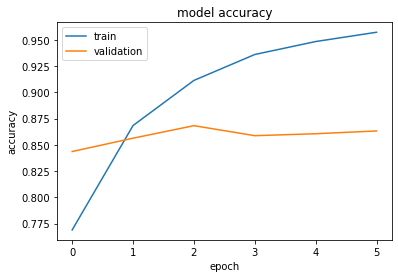

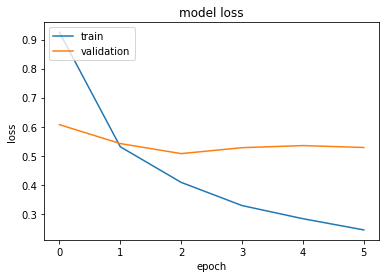

In [26]:
plot_curves(history2)

In [34]:
name ="CNN/CNN-n1.64n2.64-kr0015-vacc8632"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [17]:
myCNN = model_load("../models/CNN/CNN-n1.64n2.64-kr0015-vacc8632.h5")

In [18]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [19]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8632275132275132

Precision:  [0.88823529 0.85093168 0.89642857 0.84646465]
Average Precision:  0.8705150472573746

Recall:  [0.71904762 0.910299   0.85084746 0.86391753]
Average nRecall:  0.8360279014425482

F1-Score:  [0.79473684 0.87961477 0.87304348 0.85510204]
Average F1-Score:  0.850624282109419


# Bi-LSTM Model

In [27]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix1, 
                           input_len, 
                           trainable=True, 
                           n1=32, n2=32, 
                           d=0.3)
myLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          15537300  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           85248     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 132       
Total params: 15,624,760
Trainable params: 15,624,760
Non-trainable params: 0
_________________________________________________________________


In [28]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=40, 
                      batch_size=64, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/40
657/657 [==============================] - 242s 368ms/step - loss: 0.5560 - acc: 0.7866 - val_loss: 0.3768 - val_acc: 0.8611
Epoch 2/40
657/657 [==============================] - 212s 323ms/step - loss: 0.2681 - acc: 0.9022 - val_loss: 0.3595 - val_acc: 0.8701
Epoch 3/40
657/657 [==============================] - 215s 327ms/step - loss: 0.1544 - acc: 0.9456 - val_loss: 0.3627 - val_acc: 0.8709
Epoch 4/40
657/657 [==============================] - ETA: 0s - loss: 0.1022 - acc: 0.9633
Training accuracy above 0.95%...so training stopped...

657/657 [==============================] - 213s 324ms/step - loss: 0.1022 - acc: 0.9633 - val_loss: 0.4162 - val_acc: 0.8680


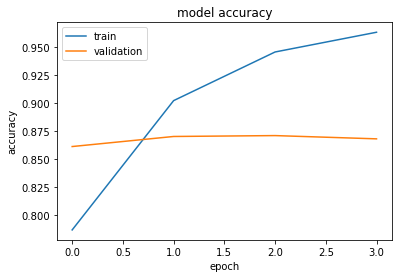

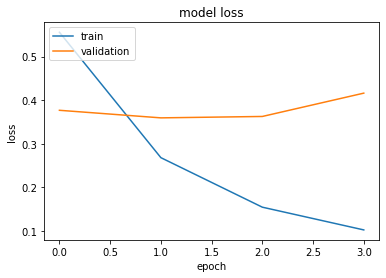

In [29]:
plot_curves(history3)

In [33]:
name= "LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [20]:
myLSTM = model_load("../models/LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868.h5")

In [21]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [22]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.867989417989418

Precision:  [0.86578947 0.86213469 0.89160839 0.85743802]
Average Precision:  0.8692426426281901

Recall:  [0.78333333 0.90166113 0.86440678 0.8556701 ]
Average nRecall:  0.85126783641381

F1-Score:  [0.8225     0.88145502 0.8777969  0.85655315]
Average F1-Score:  0.8595762668327623
